Blue model: llama3.2:latest
Red  model: llama3.2:latest

 [llama3.2:latest] sending prompt (10 lines)…

 [llama3.2:latest] answered in 3.5s → “”
 llama3.2:latest gave invalid move “”. Taking random legal edge 3.

[00] llama3.2:latest removes edge 3: A-B


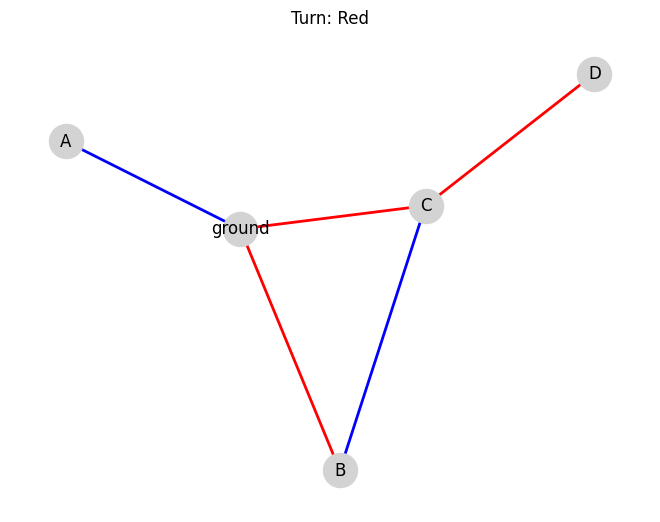


 [llama3.2:latest] sending prompt (9 lines)…

 [llama3.2:latest] answered in 0.4s → “”
 llama3.2:latest gave invalid move “”. Taking random legal edge 1.

[01] llama3.2:latest removes edge 1: ground-B


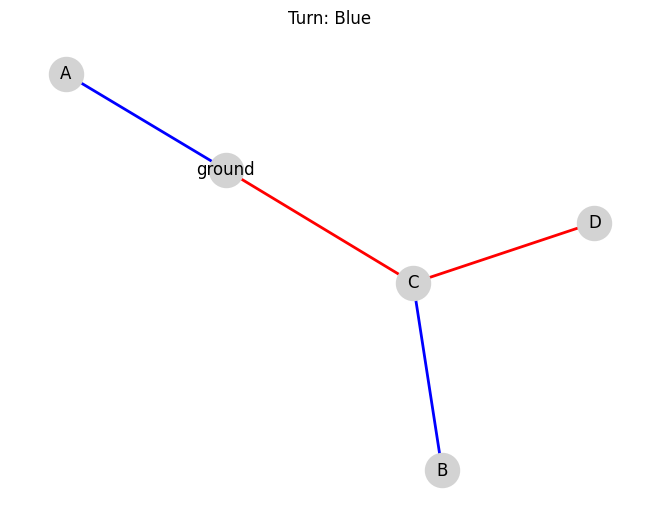


 [llama3.2:latest] sending prompt (8 lines)…

 [llama3.2:latest] answered in 0.3s → “”
 llama3.2:latest gave invalid move “”. Taking random legal edge 0.

[02] llama3.2:latest removes edge 0: ground-A


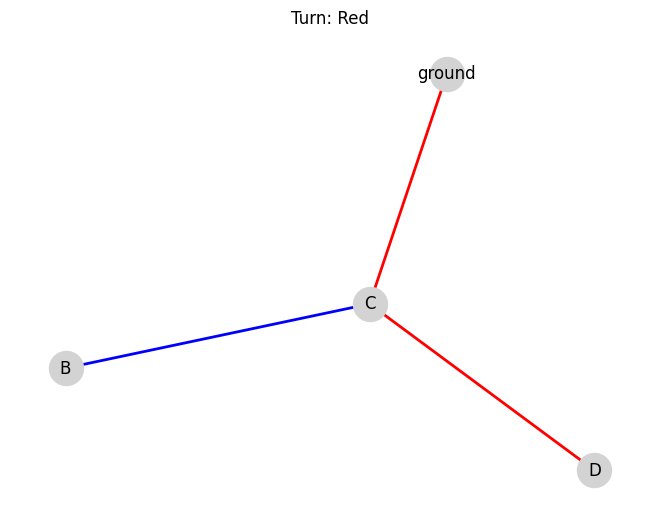


 [llama3.2:latest] sending prompt (7 lines)…

 [llama3.2:latest] answered in 0.3s → “”
 llama3.2:latest gave invalid move “”. Taking random legal edge 2.

[03] llama3.2:latest removes edge 2: C-D


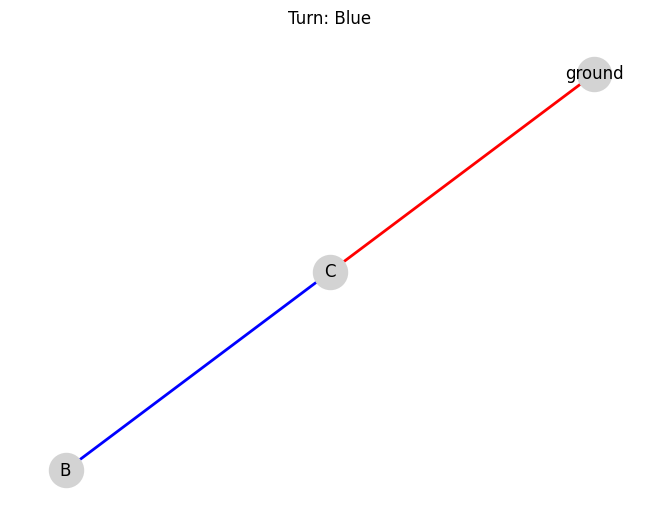


 [llama3.2:latest] sending prompt (6 lines)…

 [llama3.2:latest] answered in 0.3s → “”
 llama3.2:latest gave invalid move “”. Taking random legal edge 1.

[04] llama3.2:latest removes edge 1: B-C


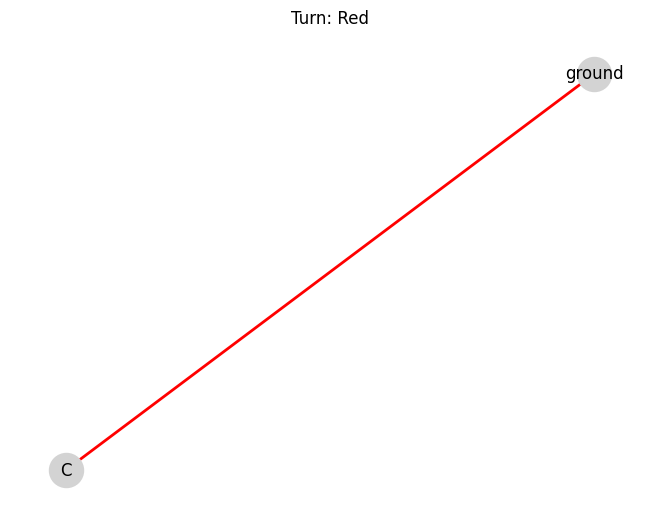


 [llama3.2:latest] sending prompt (5 lines)…

 [llama3.2:latest] answered in 0.3s → “”
 llama3.2:latest gave invalid move “”. Taking random legal edge 0.

[05] llama3.2:latest removes edge 0: ground-C


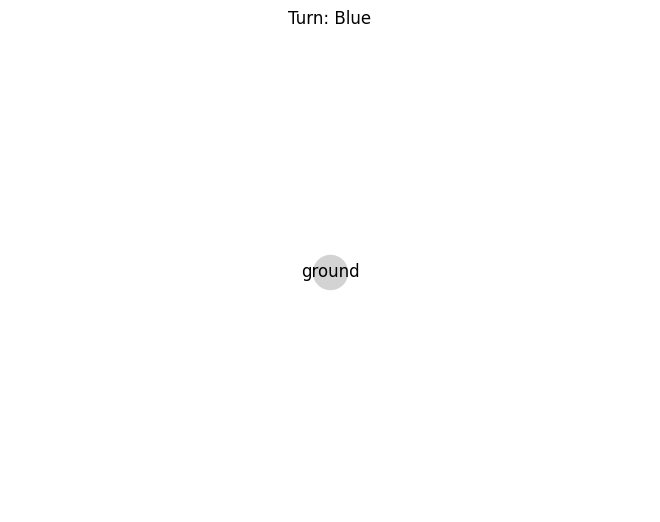


 Red (llama3.2:latest) wins – opponent has no move.


In [1]:
import time, random, re
import networkx as nx
import matplotlib.pyplot as plt
import ollama         

BLUE_MODEL = "llama3.2:latest"  
RED_MODEL  = "llama3.2:latest"   
DELAY      = 0.2        

class HackenbushGame:
    def __init__(self, edges):
        self.G = nx.Graph()
        self.G.add_node("ground") # ground node
        for u, v, col in edges:
            self.G.add_edge(u, v, color=col)
        self.turn = "B" # Blue always starts the game         

    def legal_edges(self):
        return [(i, u, v) # list of legal edges (index, node1, node2)
                for i, (u, v, d)  # d is edge data, which contains color info
                in enumerate(self.G.edges(data=True)) # enumerate edges
                if d["color"] == self.turn] # filters edges by current color

    def remove_edge(self, idx):
        u, v, _ = list(self.G.edges(data=True))[idx] # get edge data by its index
        self.G.remove_edge(u, v) # remove edge from graph

        for node in (u, v):
            if node != "ground" and not nx.has_path(self.G, "ground", node): # check if node is connected to ground
                self.G.remove_nodes_from(nx.node_connected_component(self.G, node)) # remove disconnected nodes

        self.turn = "R" if self.turn == "B" else "B" # swith turn

    def is_over(self):
        return len(self.legal_edges()) == 0 # no legal edges left

    def ascii_state(self):
        rows = []
        for i, (u, v, d) in enumerate(self.G.edges(data=True)): 
            rows.append(f"{i:2d}: {u}-{v}  ({'Blue' if d['color']=='B' else 'Red'})") # format edge info
        return "\n".join(rows)

    def draw(self): # visualize the game state
        colors = ["blue" if d["color"] == "B" else "red"
                  for _, _, d in self.G.edges(data=True)]
        nx.draw(self.G, nx.spring_layout(self.G, seed=1),
                with_labels=True, edge_color=colors, node_color="lightgray",
                node_size=600, width=2)
        plt.title(f"Turn: {'Blue' if self.turn=='B' else 'Red'}")
        plt.show()

INT_RE = re.compile(r"-?\d+") # regex pattern to get integer from LLM response (sometimes artifacts may occur)

def ensure_model(model_name: str):
    """
    Ensures if the selected model exists locally in ollama list.
    """
    try:
        raw = ollama.list()
    except Exception as e:
        print(f" Can't fetch ollama list:: {e}")
        raw = {}

    local_names = set()
    models_block = raw.get("models", raw)         
    if isinstance(models_block, list):
        for m in models_block:
            if isinstance(m, dict):
                local_names.add(m.get("name") or m.get("model") or "")
            else:                                
                local_names.add(str(m))
    elif isinstance(models_block, dict):
        local_names.add(models_block.get("name") or models_block.get("model", ""))
    else:
        pass 
    if model_name not in local_names:
        try:
            ollama.pull(model=model_name)
        except Exception as e:
            raise RuntimeError(f"Pull '{model_name}' doesn't exist locally: {e}")


def query_ollama(model: str, prompt: str, silent=False) -> str:
    """ 
    Sends a prompt to the specified LLM model using Ollama and returns the response.
    """
    ensure_model(model)
    if not silent:
        print(f"\n [{model}] sending prompt ({len(prompt.splitlines())} lines)…")
    t0 = time.time()
    chunks = []
    try:
        for chunk in ollama.chat(
                model=model,
                messages=[{"role": "system", "content": prompt}],
                stream=True):
            token = chunk["message"]["content"]
            chunks.append(token)
            if not silent:
                print(token, end="", flush=True)     
    except Exception as e:
        print(f"\nError contacting {model}: {e}")
        return ""
    if not chunks:
        print(f"\n{model} returned no content.")
        return ""
    txt = "".join(chunks).strip()
    dt  = time.time() - t0
    print(f"\n [{model}] answered in {dt:.1f}s → “{txt}”")
    return txt

def extract_index(text: str, legal):
    """ Extracts an integer index from LLM response using regex"""
    m = INT_RE.search(text)
    if m:
        val = int(m.group())
        if val in legal:
            return val
    return None

def llm_move(game, model_name):
    legal = game.legal_edges()
    if not legal:
        return None
    legal_ids = [i for i, _, _ in legal]

    prompt = (
        "You are playing Red–Blue Hackenbush. "
        f"It's your turn ({'Blue' if game.turn=='B' else 'Red'}).\n"
        "Return ONLY one integer – the index of the edge you remove. No explanation.\n\n"
        "Edges (index: endpoints (owner)):\n"
        + game.ascii_state()
    )
    raw = query_ollama(model_name, prompt)
    move = extract_index(raw, legal_ids)
    if move is None:
        move = random.choice(legal_ids)
        print(f" {model_name} gave invalid move “{raw}”. Taking random legal edge {move}.")
    return move

start_edges = [
    ("ground", "A", "B"),
    ("ground", "B", "R"),
    ("A", "B", "B"),
    ("B", "C", "B"),
    ("C", "ground", "R"),
    ("C", "D", "R"),
]

game = HackenbushGame(start_edges)
step = 0
print("Blue model:", BLUE_MODEL)
print("Red  model:", RED_MODEL)

while True:
    if game.is_over():
        winner = "Red ("+RED_MODEL+")" if game.turn == "B" else "Blue ("+BLUE_MODEL+")"
        print(f"\n {winner} wins – opponent has no move.")
        break

    model = BLUE_MODEL if game.turn == "B" else RED_MODEL
    idx = llm_move(game, model)
    u, v, _ = list(game.G.edges(data=True))[idx]
    print(f"\n[{step:02d}] {model} removes edge {idx}: {u}-{v}")
    game.remove_edge(idx)
    step += 1
    time.sleep(DELAY)
    game.draw()  
